<a href="https://colab.research.google.com/github/Violet135/NLP/blob/main/NLP_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1


## Install and Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import re

## Connect with Google Drive and import dataset

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
FOLDERNAME = "Courses/NLP/Assignment1/"
%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content


In [ ]:
!unzip Assignment1/datasets/corpus.zip -d Assignment1/datasets/

Archive:  Assignment1/datasets/corpus.zip
  inflating: Assignment1/datasets/valid.rar  
  inflating: Assignment1/datasets/train.rar  


In [ ]:
!unrar x 'Assignment1/datasets/valid.rar' 'Assignment1/datasets/'
!unrar x 'Assignment1/datasets/train.rar' 'Assignment1/datasets/'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Assignment1/datasets/valid.rar

Extracting  Assignment1/datasets/valid.json                               42% 84% 99%  OK 
All OK

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Assignment1/datasets/train.rar

Extracting  Assignment1/datasets/train.json                                6% 12% 19% 25% 32% 38% 45% 51% 58% 64% 71% 77% 84% 90% 96% 99%  OK 
All OK


In [ ]:
with open('Assignment1/datasets/train.json', 'rU') as f:
   train = pd.read_json('Assignment1/datasets/train.json', lines=True, encoding='utf-8')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


In [ ]:
with open('Assignment1/datasets/valid.json', 'rU') as f:
   valid = pd.read_json('Assignment1/datasets/valid.json', lines=True, encoding='utf-8')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


In [ ]:
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,99960,99961,99962,99963,99964,99965,99966,99967,99968,99969,99970,99971,99972,99973,99974,99975,99976,99977,99978,99979,99980,99981,99982,99983,99984,99985,99986,99987,99988,99989,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,به گزارش\r\nگروه وبگردی باشگاه خبرنگاران جوان\...,به گزارش خبرنگار\r\nگروه استان‌های\r\n\r\nباشگ...,به گزارش خبرنگار\r\nگروه استان‌های\r\n\r\nباشگ...,به گزارش\r\nگروه استان‌های\r\n\r\nباشگاه خبرنگ...,رضوی گفت: اکیپ‌های گشت و بازرسی همچون گذشته مس...,به گزارش\r\nگروه استان‌های\r\n\r\nباشگاه خبرنگ...,به گزارش\r\nخبرنگار فوتبال و فوتسال\r\n\r\nگرو...,به گزارش\r\nخبرنگار فوتبال و فوتسال\r\n\r\nگرو...,به گزارش\r\nگروه استان‌های\r\n\r\nباشگاه خبرنگ...,به گزارش\r\nگروه استان‌های\r\n\r\nباشگاه خبرنگ...,به گزارش\r\nگروه فیلم و صوت\r\n\r\nباشگاه خبرن...,به گزارش\r\n\r\nگروه استان‌های\r\n\r\nباشگاه خ...,به گزارش\r\nگروه استان‌های\r\n\r\nباشگاه خبرنگ...,به گزارش\r\nگروه اجتماعی باشگاه خبرنگاران جوان...,به گزارش\r\nگروه ورزش باشگاه خبرنگاران جوان\r\...,مدیر عامل جمعیت هلال احمر استان کردستان\r\nدر ...,جذاب‌ترین و پربازدیدترین فیلم‌های\r\nگروه فیلم...,به گزارش\r\nگروه بین‌الملل باشگاه خبرنگاران جو...,به گزارش\r\nگروه استان‌های\r\nباشگاه خبرنگاران...,به گزارش\r\nگروه وبگردی باشگاه خبرنگاران جوان\...,به گزارش\r\n\r\nگروه فیلم و صوت\r\n\r\nباشگاه ...,به گزارش\r\nگروه اجتماعی باشگاه خبرنگاران جوان...,حجت الاسلام مسعود قربانی معاون فرهنگی اوقاف و ...,به گزارش خبرنگار\r\nگروه استان‌های\r\n\r\nباشگ...,به گزارش\r\nگروه وبگردی باشگاه خبرنگاران جوان\...,به گزارش\r\n\r\nگروه اقتصادی باشگاه خبرنگاران ...,به گزارش\r\nگروه وبگردی باشگاه خبرنگاران جوان\...,به گزارش\r\nگروه استان‌های\r\nباشگاه خبرنگاران...,به گزارش خبرنگار\r\nحوزه دفاعی امنیتی\r\n\r\nگ...,محمد جواد صفاران کارشناس و مسئول خانه نجوم مشه...,به گزارش خبرنگار\r\nحوزه اخبار داغ\r\n\r\nگروه...,به گزارش\r\nگروه استان‌های\r\nباشگاه خبرنگاران...,رضا جهینی مدیر امور آب مهاباد در گفتگو با خبرن...,یوسفی معاون راهداری اداره کل راهداری و\r\nحمل ...,به گزارش\r\n\r\nگروه وبگردی باشگاه خبرنگاران ج...,به گزارش\r\nگروه بین‌الملل باشگاه خبرنگاران جو...,به گزارش\r\n\r\nخبرنگار دنیای ورزش گروه ورزشی ...,به گزارش\r\n\r\nگروه اقتصادی باشگاه خبرنگاران ...,به گزارش خبرنگار\r\nگروه استان‌های\r\n\r\nباشگ...,به گزارش خبرنگار\r\nگروه استان‌های\r\n\r\nباشگ...,...,به گزارش خبرگزاری فارس از شهرستان نور، حجت‌الا...,به گزارش خبرگزاری فارس از سمنان، سیدمجتبی اشرف...,به گزارش خبرگزاری فارس از اهواز، عصر امروز با ...,به گزارش گروه اجتماعی_اقتصادی خبرگزاری فارس اس...,به گزارش خبرگزاری فارس از اراک، اسماعیل جبارزا...,به گزارش خبرگزاری فارس، الکساندر\r\nچفرین\r\nر...,پیشرفت صنعت دندانپزشکی ایران در سال‌های گذشته ...,به گزارش خبرگزاری فارس از زنجان، مرتضی تمجیدی ...,به گزارش خبرنگار اقتصادی\r\nخبرگزاری فارس\r\n،...,به گزارش خبرگزاری فارس از بروجرد،احمد صافی ظهر...,به گزارش\r\nخبرگزاری فارس\r\nبه نقل از مرکز\r\...,به گزارش خبرگزاری فارس، سرنا ویلیامز و اندی ما...,به گزارش\r\nخبرگزاری فارس\r\nاز تبریز، مسابقات...,به گزارش خبرگزاری فارس از اصفهان، شهرام عروف‌ز...,به گزارش\r\nخبرگزاری فارس\r\n، نخستین نشست یک ...,به گزارش خبرگزاری فارس از سمنان، دو طرح فرهنگی...,به گزارش خبرگزاری فارس از اراک به نقل از پایگا...,به گزارش خبرگزاری فارس به نقل از پایگاه خبری و...,به گزارش خبرگزاری فارس از ارومیه، محمد حضرت‌پو...,به گزارش خبرگزاری فارس، دور نهم و پایانی رقابت...,به گزارش\r\nخبرگزاری فارس\r\nاز کرمان، حجت‌الا...,به گزارش خبرگزاری فارس، نیمار امروز در مصاحبه ...,به گزارش خبرگزاری فارس، مرحله اول رقابت‌های ان...,به گزارش خبرگزاری فارس از شهرستان سیمرغ، سیدمح...,به گزارش خبرگزاری فارس از کرمان، حجت‌الاسلام ک...,به گزارش خبرگزاری فارس از همدان، نمازجمعه این ...,علیرضا نصر اصفهانی امروز در گفت‌وگو با خبرنگار...,به گزارش خبرگزاری فارس از دزفول، صادق حقیقت پو...,مجتبی شاکری در گفت‌وگو با خبرنگار فارس در خلیل...,به گزارش خبرگزاری فارس از خواف، محمد سعیدی‌کیا...,مهرلله رخشانی‌مهر در گفت‌وگو با خبرنگار فارس د...,به گزارش\r\nخبرگزاری فارس\r\nبه نقل از اداره ک...,به گزارش\r\nخبرگزاری فارس\r\nبه نقل از 

In [ ]:
train[135][0]

'به گزارش خبرنگار\r\nگروه استان\u200cهای\r\n\r\nباشگاه خبرنگاران جوان\r\n\r\nاز\r\nمشهد\r\n،سرهنگ حسین دهقان پور فرمانده انتظامی شهرستان نیشابور گفت: با هدف ارتقای\r\nفرهنگ عبور و مرور،\r\nروان سازی ترافیک و ایجاد انضباط ترافیکی به ویژه در\r\nمناطق گردشگری و تاریخی\r\nاطراف آرامگاه\u200cهای خیام و عطار پلیس دوچرخه سوار راه اندازی شده است.\r\nوی افزود: وظیفه\r\nپلیس دوچرخه سوار\r\nراهنمایی و رانندگی در این محدوده\u200cها برخورد با تخلفات است و بسیار خوب است که پلیس در زمینه استفاده از این وسیله پاک پیشقدم شده است.\r\nانتهای پیام//م. م\r\n\r\n\r\nطرح\u200cهای جدید پلیس راهنمایی و رانندگی نیشابور'

In [ ]:
# Because waiting for the train set to run was a lot

mask = list(range(1000))
train_try = train[mask]

train = train_try 

# Language Model Class



In [ ]:
class LanguageModel():

    def __init__(self, data, n=2, smoothing_type=False): 
        # I replaced the corpus_dir with corpus because I read data in section 1
        self.n = n
        self.corpus = self.read_data(data)
        self.smoothing_type = smoothing_type
        self.uni = self.train_unigram()
        # Section 1.6
        # self.corpus = self.replace_with_UNK()  # There is BUG :( so I don't run this part
        self.bi = False
        if n==2:
            self.bi = self.train_bigram()
        self.tri = False
        if n==3:
            self.tri = self.train_trigram()
    def read_data(self, data):
        # in: training data
        # out: create the corpus
        corpus = []
        for index in np.arange(data.shape[1]):
            if type(data[index][0]) != str:
                continue
            # print(data[index][0])
            all_sentences = self.split_paragraph(data[index][0])
            for sentence in all_sentences:
                corpus = corpus + (self.normalize(self.tokenize(sentence)))
        return corpus

    def tokenize(self, sentence):
        # in: a srting 
        # out: a list of words
        return sentence.split(' ')
    
    def split_paragraph(self, paragraph):
        # in: a strig that contains some sentences
        # split a paragraph to its sentences by dot and markquestion(persian)
        # in this part I just split it by dot and absolutely it has bug because of the sentences ends in question mark
        # return re.split('. ؟', paragraph)
        return re.findall('[^.]+.', paragraph)

    def normalize(self, sentence):
        # in: list of words
        # apply the changes 
        # out: a list of words with tags of start and end
        puncs = ['!', '،', ':', '»', '«', '"', 'ـ', '؛', ',', '*', '"', "'"]
        for index1, i in enumerate(sentence):
                    # Section 1.1
                    if i in puncs:
                        sentence.remove(i)
                        continue
                    if self.isEnglish(i) and i!='.':
                        sentence.remove(i)
                        continue
                    # Section 1.2
                    if i.isdigit():
                        sentence[index1]="N"         
                        continue
                    sentence[index1] = re.sub('((2[0-4]|[0-1]?[0-9]):([0-5][0-9]|[0-9]))', 'N', i)
                    sentence[index1] = re.sub('((۲[۰-۴]|[۰-۱]?[۰-۹]):([۰-۵][۰-۹]|[۰-۹]))', 'N', i)
        return ['<s>'] + sentence + ['</s>']
    
    def isEnglish(self, s):
        try:
            s.encode(encoding='utf-8').decode('ascii')
        except UnicodeDecodeError:
            return False
        else:
            return True
    
    def number_of_all_tokens(self):
        # Section 1.3
        return len(self.corpus)
    
    def number_of_all_unique_tokens(self):
        # Section 1.3
        return len(self.uni[0])

    def most_frequent_words(self, number = 50):
        # Section 1.4 (Frecuency of words)
        sorted_dict = sorted(self.uni[1].items(), key=lambda x: x[1], reverse=True)
        most_frequent = sorted_dict[:number]
        most_frequent = pd.DataFrame(np.array([list(item) for item in most_frequent]))
        most_frequent[1] = most_frequent[1].apply(lambda x: int(x))
        return most_frequent

    def write_frequent(self, number):
        # Section 1.4
        words = (self.most_frequent_words(number))[0]
        with open('/gdrive/My Drive/most_frequent.txt', 'w') as f:
            for i in words:
                string = i + '\n'
                f.write(string)
        # !cat '/gdrive/My Drive/most_frequent.txt'
        print('Done!')


    def replace_with_UNK(self, corpus=False):
        # Section 1.6
        most_frequent = self.most_frequent_words()[0]
        new = []
        if not corpus:
            corpus = self.corpus
        for i in corpus:
            if i in most_frequent:
                new.append(i)
            else:
                new.append('UNK')
        return new
    
    def write_sentences(self):
        # Section: 1.7
        print('Not yet!')

    def train(self): 
        if self.n==1:
            return self.train_unigram()
        if self.n==2:
            return self.train_bigram()
        if self.n == 3:
            return self.train_trigram()

    def train_unigram(self, corpus=False):
        # in: a corpus that contains words
        # create a list of uni and a dictionary of frequency of words
        dictionary = {'N': 0, '<s>':0, '</s>':0} # unique words with frequency
        if not corpus:
            corpus = self.corpus
        for word in corpus:
            if word in dictionary:
                dictionary[word] += 1
            else: dictionary[word] = 1
        return corpus, dictionary

    def train_bigram(self, corpus=False):
        # in: a corpus that contains words
        # create a list of bigrams and a dictionary of frequency of bigrams
        if not corpus:
            corpus=self.corpus
        bigrams = []
        bigrams_table = {}
        # corpus= self.corpus
        for i in range(len(corpus)-1):
            if i < len(corpus) - 1 : 
              bigrams.append((corpus[i], corpus[i+1]))
              if (corpus[i], corpus[i+1]) in bigrams_table:
                  bigrams_table[(corpus[i], corpus[i+1])] += 1
              else:
                  bigrams_table[(corpus[i], corpus[i+1])] = 1
        return bigrams, bigrams_table

    def train_trigram(self, corpus=False):
        # in: a corpus that contains words
        # create a list of trigrams and a dictionary of frequency of trigrams
        if not corpus:
            corpus=self.corpus
        trigrams = []
        trigrams_table = {}
        for i in range(len(corpus)-2):
            if i < len(corpus) - 2 : 
              trigrams.append((corpus[i], corpus[i+1], corpus[i+2]))
              if (corpus[i], corpus[i+1], corpus[i+2]) in trigrams_table:
                  trigrams_table[(corpus[i], corpus[i+1], corpus[i+2])] += 1
              else:
                  trigrams_table[(corpus[i], corpus[i+1], corpus[i+2])] = 1
        return trigrams, trigrams_table

    def prob(self, sentence, n):
        probability = 1.0
        sentence = self.normalize(self.tokenize(sentence))
        # corpus_uni, dictionary_uni = self.train_unigram()
        if n==1:
            sentence_uni = self.train_unigram(corpus=sentence)[0]
            for ngram in sentence_uni:
                p = self.smoothing(n, ngram)
                probability *= p#(ngram=ngram, n=1, tuple_of_corpus=self.train_unigram(), delta=0)
        if n==2:
            sentence_bi = self.train_bigram(corpus=sentence)[0]
            for ngram in sentence_bi:
                probability *= self.smoothing(n, ngram)
        if n==3:
            sentence_tri = self.train_trigram(corpus=sentence)[0]
            for ngram in sentence_tri:
                probability *= self.smoothing(n, ngram)
        return probability


    def smoothing(self, n, ngram):
        # Redirect to the correct smoothing method
        if not self.smoothing_type:
            return self.smoothing_laplace(n, ngram, delta=0)
        if self.smoothing_type == 'laplace':
            return self.smoothing_laplace(n, ngram, delta=1)
        if self.smoothing_type == 'kneser-ney':
            return self.smoothing_kneser(n, ngram)

    def smoothing_laplace(self, n, ngram, delta = 1):
        if n==1:
            count = 0
            if ngram in self.uni[1] :
                count = self.uni[1][ngram]
            numerator = delta + count #corpus.count(ngram)
            denominator = delta*self.number_of_all_unique_tokens() + len(self.corpus)#corpus.prefix_count(ngram)
            p = (numerator / float(denominator))
            return p
        if n==2:
            count = 0
            if ngram in self.bi[1] :
                count = self.bi[1][ngram]
            numerator = delta + count
            denominator = delta*self.number_of_all_unique_tokens() + self.uni[1][ngram[0]]#corpus.prefix_count(ngram)
            p = (numerator / float(denominator))
            return p
        return 0

    def smoothing_kneser(self, ngram, n):
        print('Not yet!')
        return 0

    def generate(self, sentence, n):
        sentence = self.normalize(self.tokenize(sentence))
        if n==1:
            return self.most_frequent_words()[0][0]
        # if n==2:
        #     return 2
        # if n==3:
        #     return 3
        return n

    def evaluate(self):
        pass

# Run 

In [ ]:
# Writing to text file 
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
ml = LanguageModel(train, n=1)

# Section 1.3
print()
print('- - - - - - - Section 1.3')
print('Number of all tokens:\t',ml.number_of_all_tokens())
print('Number of unique tokens:', ml.number_of_all_unique_tokens())

# Section 1.4
print()
print('- - - - - - - Section 1.4')
ml.write_frequent(number = 10000)

# Section 1.5
print()
print('- - - - - - - Section 1.5')
print((np.sum(ml.most_frequent_words(number=10000)[1]+0.0)/(ml.number_of_all_tokens())*100), ' %')


- - - - - - - Section 1.3
Number of all tokens:	 334428
Number of unique tokens: 334428

- - - - - - - Section 1.4
Done!

- - - - - - - Section 1.5
91.47708923893933  %


In [ ]:
# # Section 1.7
# print()
# print('- - - - - - - Section 1.7')


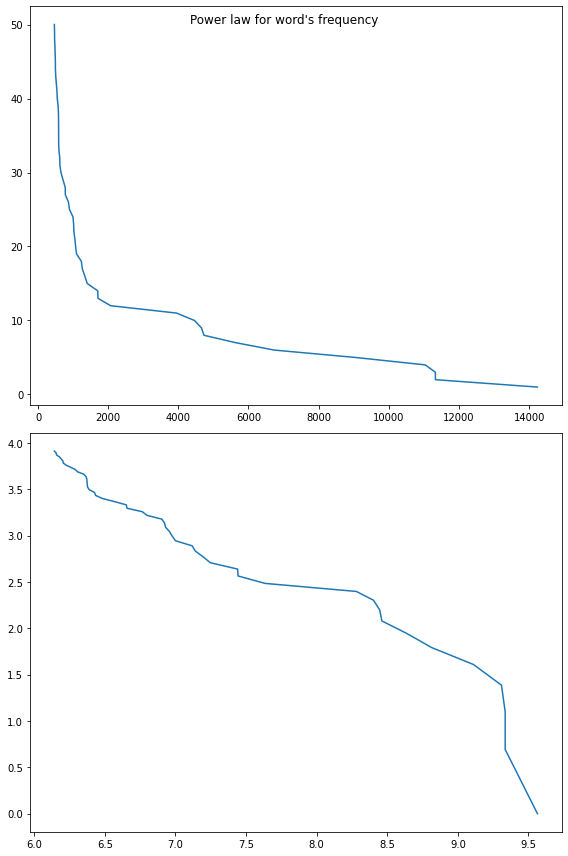

In [ ]:
# Section: 1.8 (Power law)
most = ml.most_frequent_words()
y = np.arange(1, most.shape[0]+1)
x = np.array(most[1])

fig, axs = plt.subplots(2, figsize=(8,12))
fig.suptitle("Power law for word's frequency")
axs[0].plot(x, y)
axs[1].plot(np.log(x), np.log(y))
plt.tight_layout()

In [ ]:
sentence = 'گروه وبگردی باشگاه خبرنگاران جوان'

ml1 = LanguageModel(train, n=1)
print('UNI:\t', ml1.generate(sentence, 1))

ml2 = LanguageModel(train, n=2)
print('BI:\t', ml2.generate(sentence, 2))


UNI:	 و
BI:	 2


In [ ]:
# calculate probabilities

sentence = 'گروه وبگردی باشگاه خبرنگاران جوان'

print('prob without smoothing', 'unigram')
ml = LanguageModel(train, n=1)
print(ml.prob(sentence, 1), '\n')

print('prob with smoothing', 'unigram')
ml = LanguageModel(train, n=1, smoothing_type='laplace')
print(ml.prob(sentence, 1), '\n')

print('prob without smoothing', 'bigram')
ml = LanguageModel(train, n=2)
print(ml.prob(sentence, 2), '\n')

print('prob with smoothing', 'bigram')
ml = LanguageModel(train, n=2, smoothing_type='laplace')
print(ml.prob(sentence, 2), '\n')


prob without smoothing unigram
1.42942371523117e-19 

prob with smoothing unigram
1.1587493903101448e-21 

prob without smoothing bigram
0.0 

prob with smoothing bigram
3.74102217372605e-28 



In [ ]:
# Create 3 language model 

ml1 = LanguageModel(train, n=1)
uni, uni_table = ml1.train()
print('number of uni_table: \t', len(uni_table))

ml2 = LanguageModel(train, n=2)
bi, bi_table = ml2.train()
print('number of bi_table: \t', len(bi_table))

ml3 = LanguageModel(train, n=3)
tri, tri_table = ml3.train()
print('number of tri_table: \t', len(tri_table))

number of uni_table: 	 34794
number of bi_table: 	 166549
number of tri_table: 	 257018
